In [1]:
cd /home

/home


In [2]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import os

from sklearn.metrics import f1_score

os.environ["CUDA_VISIBLE_DEVICES"]='-1'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
aesthetics = {
    'lstm': {
        'linestyle':':',
        'marker': 's',
        'color':'k'
    },
    'lstm_att': {
        'linestyle':'--',
        'marker': 'o',
        'color':'k'
    },
    'mlp_att': {
        'linestyle':'-',
        'marker': '^',
        'color':'k'
    },
}

In [4]:
def get_prediction(path):
    with open(path, 'rb') as handle:
        dic = pickle.load(handle)
    return dic

In [5]:
# exp_path = os.path.join(root_dir, 
#                         'fold_{}'.format(fold), 
#                         '{}_{}'.format(ds_name, subset), 
#                         clf_model, 
#                         'results.pkl')

In [6]:
def get_f1_from_folds(ds_name, root_dir, clf_model, average=False):
    results_list = []
    for subset in [20, 50, 100, 500]:
        folds_res = []
        for fold in range(3):
            exp_path = os.path.join(root_dir, 
                                    'fold_{}'.format(fold), 
                                    '{}_{}'.format(ds_name, subset), 
                                    clf_model, 
                                    'summary.pkl')
            res_dic = get_prediction(exp_path)
            
            folds_res.append(res_dic['classification']['f1'])
            
        results_list.append(folds_res) 
    results_list = np.array(results_list)
    if average:
        return np.mean(results_list, 1), np.std(results_list, 1)
    else:
        return results_list

In [7]:
def get_plot(mean_values, std_values, ax, style, label):
    x_range = range(len(mean_values))
    ax.plot(x_range, mean_values, 
            linestyle=style[clf_model]['linestyle'], 
            marker=style[clf_model]['marker'], 
            color=style[clf_model]['color'], label=label)
    ax.fill_between(x_range, mean_values+std_values, mean_values-std_values, alpha=0.1, 
                    color=style[clf_model]['color'])
    return ax

In [8]:
pt_model = './runs/astromer_256_rf/'

Text(0.06, 0.5, 'F1 Score')

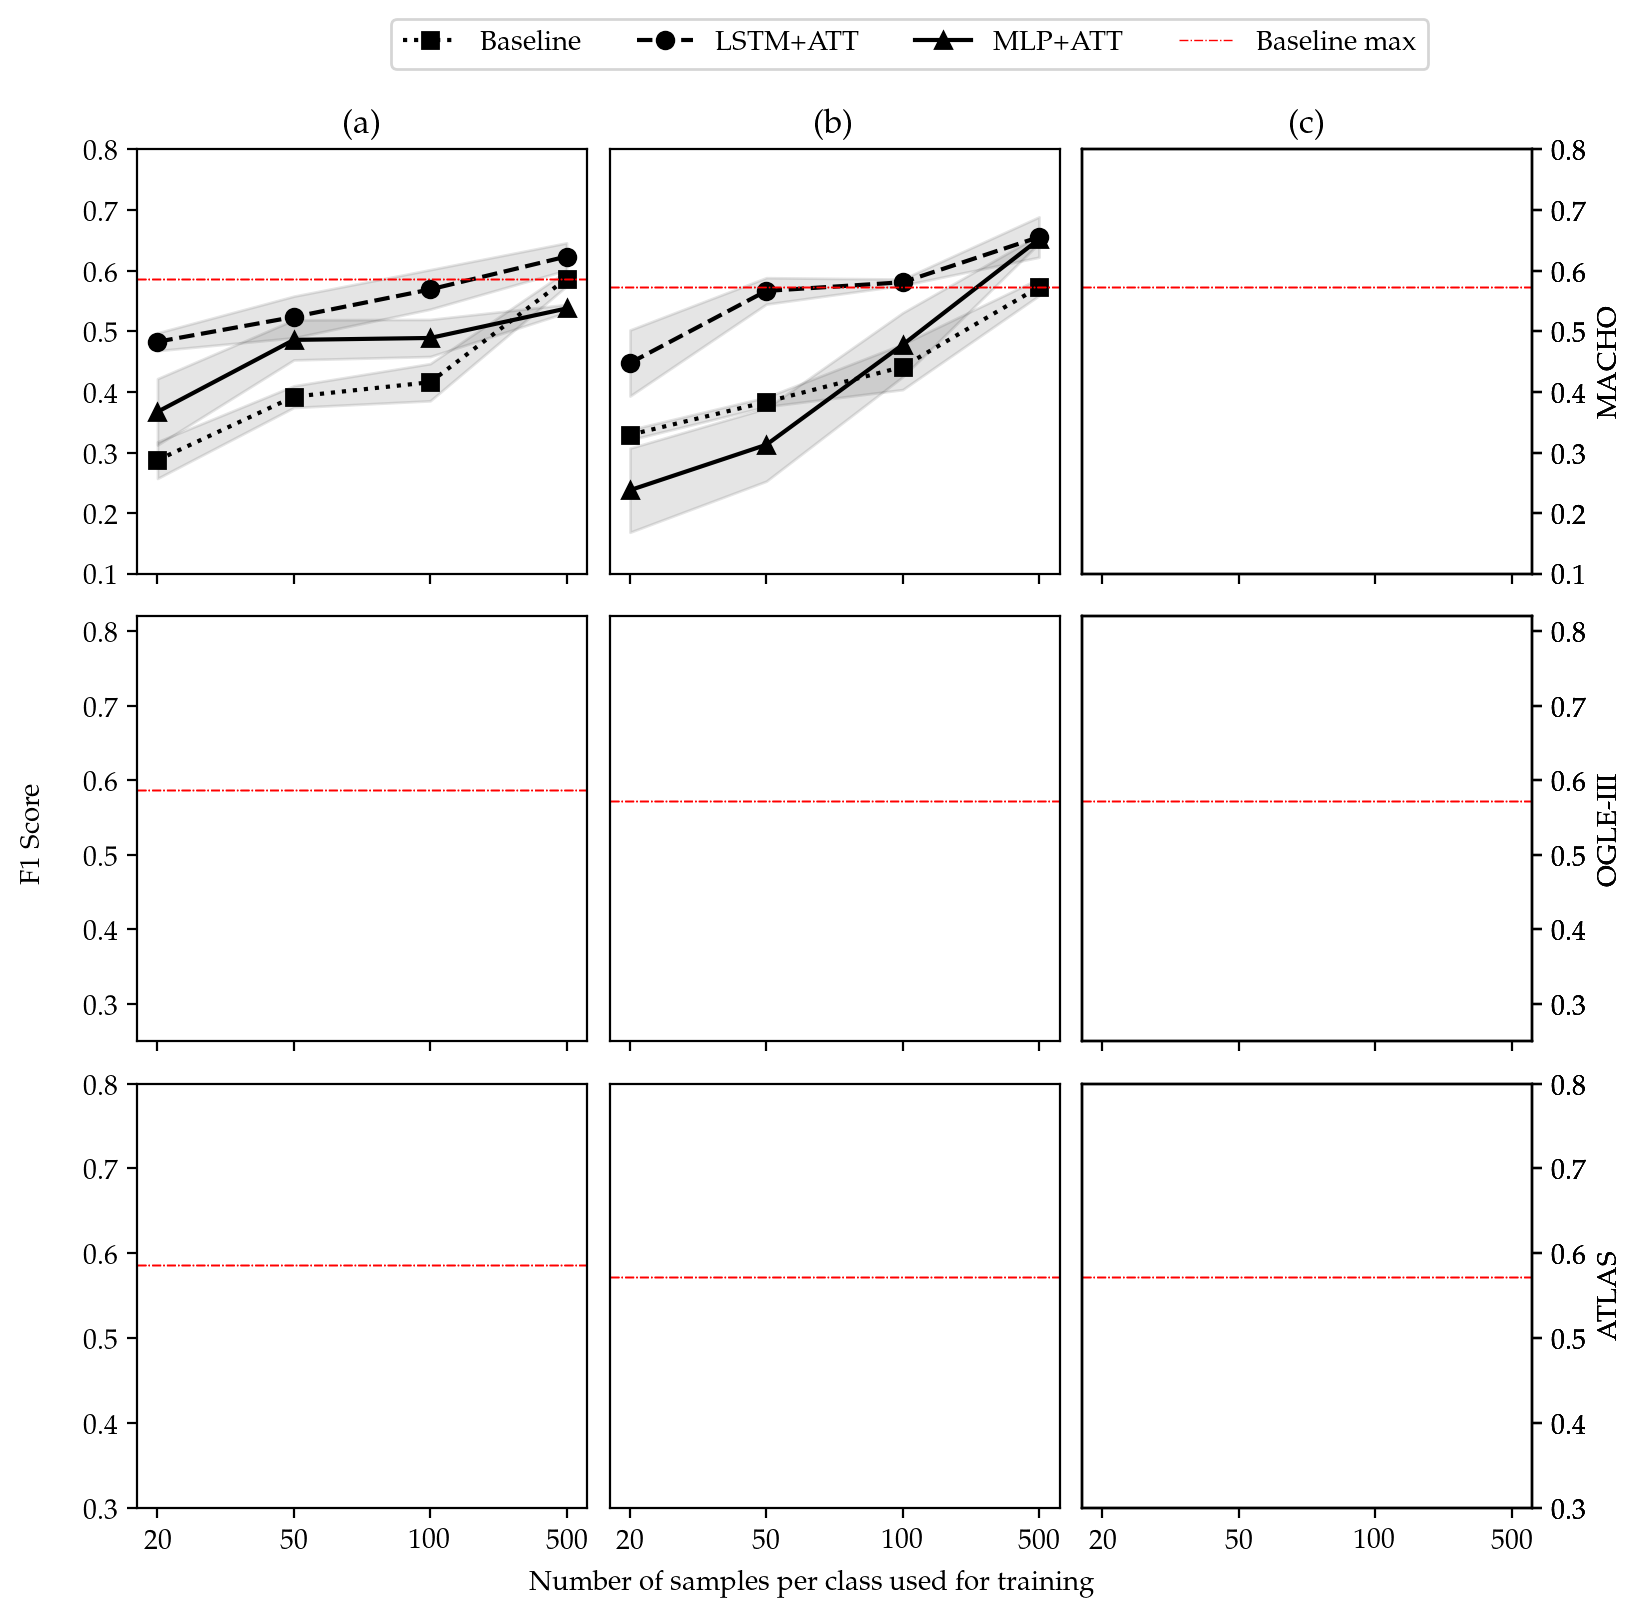

In [10]:
fig, axes = plt.subplots(3,3, figsize=(9,9), 
                         sharex=True, 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, 
                        dpi=200)

for i, exp in enumerate(['a', 'b', 'c']):
    for k, ds_name in enumerate(['alcock', 'ogle', 'atlas']):
        
        if ds_name == 'alcock': 
            title_ds ='MACHO'
        if ds_name == 'ogle': 
            title_ds ='OGLE-III'
        if ds_name == 'atlas': 
            title_ds ='ATLAS'
        
        root_dir = '{}/classifiers/{}/{}'.format(pt_model, exp, ds_name)
        if k == 0:
            axes[k][i].set_title("({})".format(exp))
            
        clf_models = ['lstm', 'lstm_att', 'mlp_att']
        for index, clf_model in enumerate(clf_models):
            if clf_model == 'lstm': model_lab='Baseline'
            if clf_model == 'lstm_att': model_lab='LSTM+ATT'
            if clf_model == 'mlp_att': model_lab='MLP+ATT'
                
            try:
                if '_att' in clf_model:
                    _mean, _std = get_f1_from_folds(ds_name, root_dir, '{}'.format(clf_model), average=True)
                else:
                    _mean, _std = get_f1_from_folds(ds_name, root_dir, clf_model, average=True)
                    
                axes[k][i] = get_plot(_mean, _std, axes[k][i], style=aesthetics, label=model_lab)   
                
                if clf_model == 'lstm':
                    base_f1 = _mean
            except Exception as e:
                pass
                
            if i > 0:
                axes[k][i].set_yticks([])
                
            x_range = range(len(_mean))
            axes[k][i].set_xticks(x_range)
            axes[k][i].set_xticklabels([20, 50, 100, 500], rotation=0)
            
            if i == 2:
                ax2 = axes[k][i].twinx() 
                ax2.set_ylabel(title_ds)
                
            
            if k == 0:
                axes[k][i].set_ylim(0.1, 0.8)
                if i == 2:
                    ax2.set_ylim(0.1, 0.8)
                    
            if k == 1:
                axes[k][i].set_ylim(0.25, 0.82)
                if i == 2:
                    ax2.set_ylim(0.25, 0.82)
            if k == 2:
                axes[k][i].set_ylim(0.3, 0.8)
                if i == 2:
                    ax2.set_ylim(0.3, 0.8)
            
            if k == 0 and i == 0 and index==2:
                axes[k][i].axhline(y=base_f1.max(), color='r', linestyle='-.',label='Baseline max',
                   linewidth=0.5)
                fig.legend(bbox_to_anchor=(0.85, 0.96), ncol=4)
            else:
                axes[k][i].axhline(y=base_f1.max(), color='r', linestyle='-.', linewidth=0.5)
        
        
        
fig.text(0.5, 0.08, 'Number of samples per class used for training', ha='center')
fig.text(0.06, 0.5, 'F1 Score', va='center', rotation='vertical')

In [33]:
fig.savefig('presentation/figures/clf_exp.pdf', format='pdf', bbox_inches='tight')

## Varying the head-size of ASTROMER   

Text(0.03, 0.5, 'F1 Score')

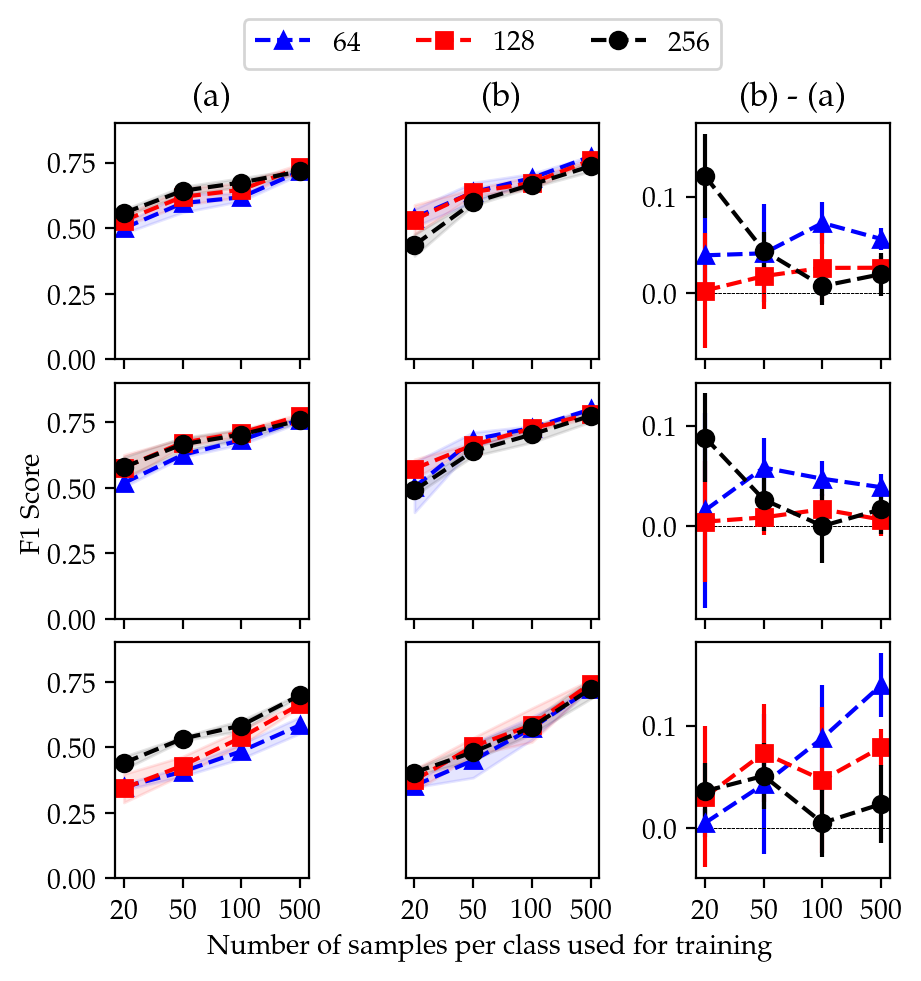

In [15]:
fig, axes = plt.subplots(3,3, figsize=(5,5), 
                         sharex=True, 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.5}, 
                        dpi=200)

colors = {
    64:'blue',
    128:'red',
    256:'k'
}

markers = {
    64:'^', 
    128:'s',
    256:'o'
}

for dim in [64, 128, 256]:
    pt_model = './runs/astromer_{}/'.format(dim)
    
    for i, exp in enumerate(['a', 'b']):
        for k, ds_name in enumerate(['alcock', 'ogle', 'atlas']):

            if ds_name == 'alcock': 
                title_ds ='MACHO'
            if ds_name == 'ogle': 
                title_ds ='OGLE-III'
            if ds_name == 'atlas': 
                title_ds ='ATLAS'

            root_dir = '{}/classifiers/{}/{}'.format(pt_model, exp, ds_name)
            if k == 0:
                axes[k][i].set_title("({})".format(exp))

            clf_models = ['lstm_att']
            for index, clf_model in enumerate(clf_models):
                try:
                    _mean, _std = get_f1_from_folds(ds_name, root_dir, '{}_2'.format(clf_model), average=True)

                    x_range = range(len(_mean))
                    axes[k][i].plot(x_range, _mean, 
                            linestyle=aesthetics[clf_model]['linestyle'], 
                            marker=markers[dim], 
                            color=colors[dim], 
                            label='{}'.format(dim))
                    axes[k][i].fill_between(x_range, _mean+_std, _mean-_std, alpha=0.1, 
                                    color=colors[dim])
                
                        
                except Exception as e:
                    print(e)
                    pass

                if i > 0:
                    axes[k][i].set_yticks([])

                x_range = range(len(_mean))
                axes[k][i].set_xticks(x_range)
                axes[k][i].set_xticklabels([20, 50, 100, 500], rotation=0)

                if i == 2:
                    ax2 = axes[k][i].twinx() 
                    ax2.set_ylabel(title_ds)
                    ax2.set_ylim(0.0, 0.9)
                    

            axes[k][i].set_ylim(0.0, 0.9)
            
    for k, ds_name in enumerate(['alcock', 'ogle', 'atlas']):
        
        for i, exp in enumerate(['a', 'b']):
            root_dir = '{}/classifiers/{}/{}'.format(pt_model, exp, ds_name)
            clf_models = ['lstm_att']
            for index, clf_model in enumerate(clf_models):
                try:
                    _mean, _std = get_f1_from_folds(ds_name, root_dir, '{}_2'.format(clf_model), average=True)   
                    if i == 0:
                        partial_a = _mean 
                        partial_b = _std
                        
                except Exception as e:
                    print(e)
                    pass
            
        diff_a = abs(_mean - partial_a)
        diff_std = np.sqrt(_std**2 + partial_b**2)

        x_range = range(len(_mean))
        axes[k][-1].errorbar(x_range, diff_a, yerr=diff_std,
                linestyle=aesthetics[clf_model]['linestyle'], 
                marker=markers[dim], 
                color=colors[dim], 
#                 s=4,                
                label='{}'.format(dim))
        axes[k][-1].axhline(y=0., color='k', linestyle='--', linewidth=0.3)
        if k == 0:
            axes[k][-1].set_title('(b) - (a)')
axes[0][1].legend(bbox_to_anchor=(1.7, 1.5), ncol=4)
fig.text(0.5, 0.05, 'Number of samples per class used for training', ha='center')
fig.text(0.03, 0.5, 'F1 Score', va='center', rotation='vertical')


# Comparting times

In [36]:
cd /home

/home


In [37]:
from core.utils import get_metrics


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-
[0.8786314725875854, 0.8958727717399597, 0.8287148475646973]
[0.8325955867767334, 0.8627740144729614, 0.8331578969955444]
[0.9048654437065125, 0.9035196304321289, 1.0112143754959106]
-
[0.8858368992805481, 0.886380136013031, 0.8348744511604309]
[0.837094783782959, 0.8261070251464844, 0.8346660137176514]
[0.8610994219779968, 0.9209169745445251, 1.0166723728179932]


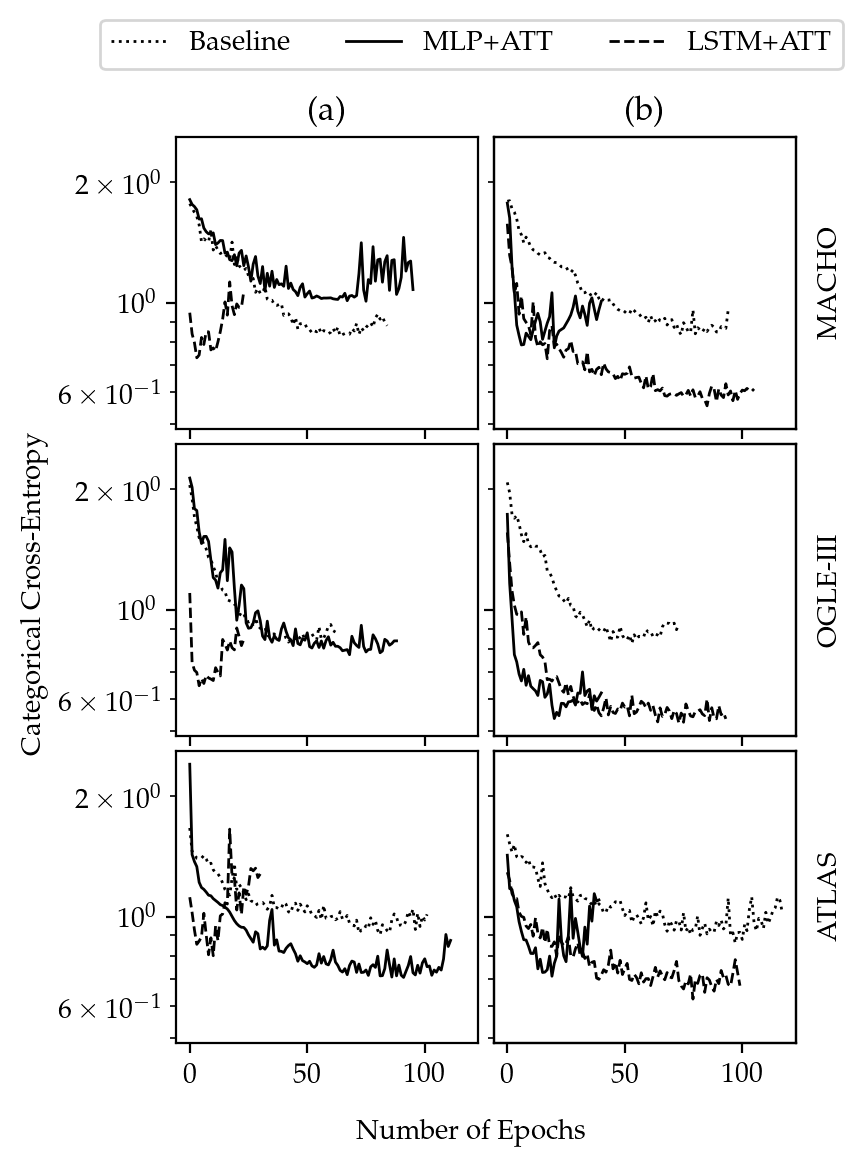

In [106]:
fig, axes = plt.subplots(3,2, sharey=True, sharex=True, figsize=(4,6), dpi=200, 
                         gridspec_kw={'hspace': 0.05, 'wspace': 0.05},)

for col, sci_case in enumerate(['a', 'b']):
    print('-')
    root = './runs/astromer_256/classifiers/{}/'.format(sci_case)
    for i, name_exp in enumerate(['alcock', 'ogle', 'atlas']):
        if i == 0:
            axes[i][col].set_title('({})'.format(sci_case))
            
        for index, (name, ls) in enumerate(zip(['lstm', 'mlp_att', 'lstm_att'], [':', '-', '--'])):
            val_metrics_list = []
            for fold_n in range(3):
                exp_folder = '{}/{}/fold_{}/{}_500/'.format(root, name_exp, fold_n, name_exp)
                if '_att' in name:
                    val_metrics = get_metrics(os.path.join(exp_folder, '{}_2'.format(name), 'logs', 'validation'), 
                                              metric_name='epoch_loss')
                else:
                    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'), 
                                              metric_name='epoch_loss')
                
                val_metrics_list.append(val_metrics)
                            
            min_steps = [float(f['value'].min()) for f in val_metrics_list]
            if name == 'lstm':
                print(min_steps)
            val_metrics = pd.DataFrame()
            val_metrics['step'] = val_metrics_list[np.argmin(min_steps)]['step']#(val_metrics_list[0]['wall_time'] - val_metrics_list[0]['wall_time'].iloc[0])/60  
            val_metrics['value'] = val_metrics_list[np.argmin(min_steps)]['value']#mean_values   

            if name =='lstm': title_name = 'Baseline'
            if name =='mlp_att': title_name = 'MLP+ATT'
            if name =='lstm_att': title_name = 'LSTM+ATT'

            axes[i][col].plot(val_metrics['value'], label=title_name, linestyle=ls, color='k', linewidth=1)

        
        if name_exp == 'alcock' and sci_case == 'b':
            ax2 = axes[i][col].twinx()
            ax2.set_ylabel('MACHO')
            ax2.set_yticks([])
            axes[i][col].legend(bbox_to_anchor=(1.2, 1.45), ncol=3)

        if name_exp == 'ogle' and sci_case == 'b':
            ax2 = axes[i][col].twinx()
            ax2.set_ylabel('OGLE-III')
            ax2.set_yticks([])

        if name_exp == 'atlas' and sci_case == 'b':
            ax2 = axes[i][col].twinx()
            ax2.set_ylabel('ATLAS')
            ax2.set_yticks([])
  
            
        axes[i][col].set_yscale('log')
fig.text(-.07, 0.5, 'Categorical Cross-Entropy', va='center', rotation='vertical')
fig.text(0.35, 0.05, 'Number of Epochs', va='center', rotation='horizontal')
fig.savefig('presentation/figures/learning_curves.pdf', format='pdf', bbox_inches='tight')